# Regularising linear regression using the ridge-gradient method

This notebook demonstrates how gradients can be leveraged to improve fitting linear regression models using the gradient regularisation method. 

In [22]:
import autograd.numpy as np
import matplotlib.pyplot as plt
from scipy import stats, spatial
import autograd as ag
from tqdm.notebook import tqdm

np.random.seed(0)

## Generating synthetic data

Synthetic data is generated over the interval $0 \leq x \leq 2 \pi$ using the function $y = sin(x) + \epsilon$ where $\epsilon \sim N(0, \sigma)$ and $\sigma = 0.1$.

A training, validation and test set are generated.

In [23]:
nTrain = 12 
nVal = 50
nTest = 100
noiseStd = 0.1
xmin = 0
xmax = 2.5 * np.pi
LAM = 0.01
func = lambda x, n: np.sin(x) + stats.norm.rvs(size=(n, 1), scale=noiseStd)
func_noNoise = lambda x: np.sin(x)
func_grad = ag.elementwise_grad(func)

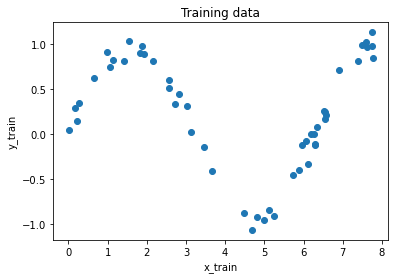

In [71]:
x_train = np.random.uniform(xmin, xmax, nTrain).reshape((nTrain, 1))
x_val = np.random.uniform(xmin, xmax, nVal).reshape((nVal, 1))
x_test = np.linspace(xmin, xmax, nTest).reshape((nTest, 1))
y_train = func(x_train, nTrain)
y_val = func(x_val, nVal)
y_test = func_noNoise(x_test)

y_train_grad = func_grad(x_train, nTrain) # Gradients are collected for improved regularisation
y_val_grad = func_grad(x_val, nVal)

plt.scatter(x_train, y_train);
plt.title('Training data');
ax = plt.gca()
ax.set_xlabel('x_train')
ax.set_ylabel('y_train');

### Transform 1D training data in to higher dimensions using radial basis functions

In order to fit non-linear data with a linear regression model the 1-dimensional input data, $x$, is transformed in to an 8 dimensional input, denoted $\Phi(X)$ using 7 radial basis functions centered at even intervals in the range $[0, 2 \pi]$. A constant term term is also added.

In [72]:
no_basis = 7
centers = np.linspace(xmin, xmax, no_basis).reshape(no_basis, 1)

In [73]:
# Transform X with RBFs
def trans(X, r=1):
    N = len(X)
    PHI = np.exp(-spatial.distance.cdist(X, centers, metric="sqeuclidean")
                 / (r**2))
    PHI = np.hstack((np.ones((N, 1)), PHI)) # Add constant
    return PHI

In [74]:
PHI_train = trans(x_train)
PHI_val = trans(x_val)
PHI_test = trans(x_test)

## Fit standard OLS regression with ridge regularisation

Standard OLS regression with ridge regularisation is fit to the data to set baseline accuracy.

In [75]:
def rmse(y, pred):
    """ Root mean squared error function to evaluate model performance.
    """
    return (sum((y - pred)** 2) / len(y)) ** 0.5

In [77]:
def fit_OLS(PHI, y, lam):
    """ Set optimal coefficients using ridge OLS solution.
    """
    w = np.linalg.solve(
        (PHI.T @ PHI +
         lam *
         np.eye(
             PHI.shape[1])),
        PHI.T @ y)
    return w

In [78]:
def fit_ridge_OLS(x_train, y_train, x_val, y_val, nLam=100):
    """ Using validation set, use brute force to determine optimal regularisation parameter lambda.
    """
    lams = np.linspace(0, 10, nLam)
    opt_lam = 0
    opt_rmse = y_val.std()
    opt_w = None
    for i in range(nLam):
        w = fit_OLS(x_train, y_train, lams[i])
        pred = x_val @ w
        acc = rmse(pred.flatten(), y_val.flatten())
        if acc < opt_rmse:
            opt_lam = lams[i]
            opt_rmse = acc
            opt_w = w
    return opt_w, opt_lam

In [79]:
beta_std, lam_opt = fit_ridge_OLS(PHI_train, y_train, PHI_val, y_val)

In [80]:
y_pred_test = PHI_test @ beta_std
y_pred_train = PHI_train @ beta_std

Optimal lambda: 0.00
Test RMSE: 0.05
y_test std: 0.69


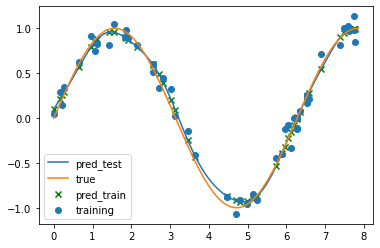

In [81]:
print(f'Optimal lambda: {lam_opt:.02f}')
print(f'Test RMSE: {rmse(y_pred_test.flatten(), y_test.flatten()):.02f}')
print(f'y_test std: {y_test.std():.02f}')

plt.plot(x_test, y_pred_test, label='pred_test')
plt.scatter(x_train, y_pred_train, label='pred_train', marker='x', c='g')
plt.plot(x_test, y_test, label='true')
plt.scatter(x_train, y_train, label='training')
plt.legend();

## Introducing gradients

We now demonstrate how the gradients of the function output with respect to its inputs $\nabla_x y = \frac{\delta y}{\delta x}$ can be incorporated in to the regularising term to improve model accuracy.

The linear model is:

$$
\hat{y} = \boldsymbol{\hat{\beta}} \ \boldsymbol{\Phi(x)} \\
\hat{y} = \hat{\beta_0} + \hat{\beta_1} \ \exp \left \{ \frac{-(x - c_1)^2}{r^2} \right \} + ... + \hat{\beta_8} \exp \left \{  \frac{-(x - c_7)^2}{r^2}\right \}
$$ 

$\boldsymbol{\hat{\beta}}$ is computed using OLS to minimise $(y - \hat{y})^2$ (with ridge regularisation), however we can also compute a coefficient vector to minimise $(\nabla_x y - \nabla_x \hat{y})^2$, denoted $\boldsymbol{\hat{\beta}_{grad}}$. 

As we have calculated and retained $\nabla_x y$, we can use OLS (again with ridge regularisation) to find $\boldsymbol{\hat{\beta}_{grad}}$. The resulting 'gradient' fitting model takes the form:

$$
\frac{\delta \hat{y}}{\delta x} = \hat{\beta_0}_{grad} + \hat{\beta_1}_{grad} \frac{-2(x - c_1)^2}{r^2} \exp \left \{ \frac{-(x - c_1)^2}{r^2} \right \} + ... + \hat{\beta_8}_{grad} \frac{-2(x - c_7)^2}{r^2} \exp \left \{ \frac{-(x - c_7)^2}{r^2} \right \}
$$

The key to understanding to following improved regularisation method is recognising that the fitted coefficients $\boldsymbol{\hat{\beta}}$ should accurately fit both $y$ and $\nabla_x y$ - the data and its gradient - and therefore the difference between $\boldsymbol{\hat{\beta}}$ and $\boldsymbol{\hat{\beta}_{grad}}$ should be minimal.

This motivates the ridge-gradient ($\boldsymbol{\hat{\beta}_{rg}}$) OLS solution:

$$
\min_{\hat{\boldsymbol{\beta}}} \ \ (y - \hat{y})^2 + \lambda_1 \hat{\boldsymbol{\beta}}^2 + \lambda_2 (\boldsymbol{\hat{\beta}} - \boldsymbol{\hat{\beta}_{grad}})^2
$$

$$
\boldsymbol{\hat{\beta}_{rg}} = (X'X + \lambda_1 I + \lambda_2 I)^{-1} (\lambda_2 \ \boldsymbol{\hat{\beta}_{grad}} + X'y)
$$

We first calculate the derivative inputs to be fit to $\nabla_x y$:

$$
constant, \frac{-2(x - c_1)^2}{r^2} \exp \left \{ \frac{-(x - c_1)^2}{r^2} \right \}, \ \frac{-2(x - c_2)^2}{r^2} \exp \left \{ \frac{-(x - c_2)^2}{r^2} \right \},..., \frac{-2(x - c_7)^2}{r^2} \exp \left \{ \frac{-(x - c_7)^2}{r^2} \right \}
$$

In [34]:
PHI_train_grad = np.zeros((nTrain, no_basis+1))
PHI_val_grad = np.zeros((nVal, no_basis+1))
PHI_test_grad = np.zeros((nTest, no_basis+1))
for c in range(no_basis+1): 
    if c == 0: # Retain bias term
        PHI_train_grad[:, c] = np.ones(nTrain)
        PHI_test_grad[:, c] = np.ones(nTest)
        PHI_val_grad[:, c] = np.ones(nVal)
    else: 
        PHI_train_grad[:, c] = (np.exp(-(x_train - centers[c-1]) ** 2) * (-2 * (x_train - centers[c-1]))).flatten()
        PHI_test_grad[:, c] = (np.exp(-(x_test - centers[c-1]) ** 2) * (-2 * (x_test - centers[c-1]))).flatten()
        PHI_val_grad[:, c] = (np.exp(-(x_val - centers[c-1]) ** 2) * (-2 * (x_val - centers[c-1]))).flatten()

Next we fit $\boldsymbol{\hat{\beta}_{grad}}$ using ridge OLS.

In [35]:
beta_grad, opt_lam_grad = fit_ridge_OLS(PHI_train_grad, y_train_grad, PHI_val_grad, y_val_grad)
print(f'Optimal lambda: {opt_lam_grad:.02f}')

Optimal lambda: 0.10


We can check that $\boldsymbol{\hat{\beta}_{grad}}$ fits the gradients of the test data better than $\boldsymbol{\hat{\beta}}$.

Standard beta test RMSE: 0.40
Beta_grad test RMSE: 0.37


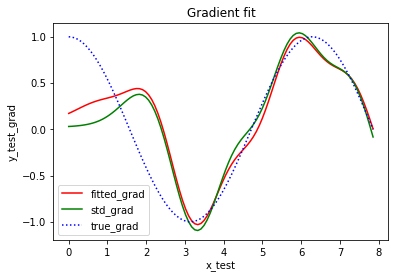

In [36]:
grad_pred_OLS_fit = PHI_test_grad @ beta_grad
grad_pred_std = PHI_test_grad @ beta_std

print(f'Standard beta test RMSE: {rmse(grad_pred_std.flatten(), np.cos(x_test).flatten()):.02f}')
print(f'Beta_grad test RMSE: {rmse(grad_pred_OLS_fit.flatten(), np.cos(x_test).flatten()):.02f}')

plt.plot(x_test, grad_pred_OLS_fit, label='fitted_grad', c='r')
plt.plot(x_test, grad_pred_std, label='std_grad', c='g')
plt.plot(x_test, np.cos(x_test), label='true_grad', c='b', linestyle=':')
plt.title('Gradient fit')
ax = plt.gca()
ax.set_xlabel('x_test')
ax.set_ylabel('y_test_grad')
plt.legend();

$\boldsymbol{\hat{\beta}_{rg}}$ can now be calculated as follows:

In [37]:
def brute_force_grad(x_train, y_train, x_val, y_val, beta_grad, nLam=100):
    lams1 = np.linspace(0, 10, nLam)
    lams2 = np.linspace(0, 10, nLam)
    opt_lam1 = 0
    opt_lam2 = 0
    opt_rmse = y_val.std() + 1
    opt_beta_rg = None
    for i in range(nLam):
        for j in range(nLam):
                beta_rg = np.linalg.solve(
                (PHI_train.T @ PHI_train +
                 lams1[i] *
                 np.eye(
                     PHI_train.shape[1]) + lams2[i] * np.eye(
                     PHI_train.shape[1])),
                lams1[i] * beta_grad.reshape((len(beta_grad), 1)) + (PHI_train.T @ y_train))
                pred = x_val @ beta_rg
                acc = rmse(pred.flatten(), y_val.flatten())
                if acc < opt_rmse:
                    opt_lam1 = lams1[i]
                    opt_lam2 = lams2[i]
                    opt_rmse = acc
                    opt_beta_rg = beta_rg
    return opt_beta_rg, opt_lam1, opt_lam2

In [38]:
beta_rg, lam1, lam2 = brute_force_grad(PHI_train, y_train, PHI_val, y_val, beta_grad)
print(f'Optimal lambda 1: {lam1:.02f}')
print(f'Optimal lambda 2: {lam2:.02f}')

Optimal lambda 1: 0.10
Optimal lambda 2: 0.10


In [39]:
y_pred_test_rg = PHI_test @ beta_rg
y_pred_train_rg = PHI_train @ beta_rg

Standard beta test RMSE: 0.35
Beta_rg test RMSE: 0.31


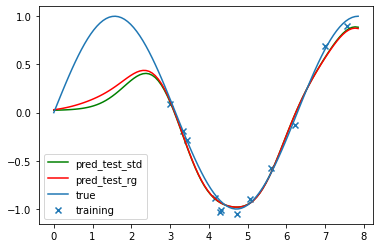

In [40]:
print(f'Standard beta test RMSE: {rmse(y_pred_test.flatten(), y_test.flatten()):.02f}')
print(f'Beta_rg test RMSE: {rmse(y_pred_test_rg.flatten(), y_test.flatten()):.02f}')


#plt.figure(figsize=(20,10))
plt.plot(x_test, y_pred_test, label='pred_test_std', c='g')
plt.plot(x_test, y_pred_test_rg, label='pred_test_rg', c='r');
#plt.scatter(x_train, y_pred_new_train, label='pred_train_new', c='r', marker='+');
#plt.scatter(x_train, y_pred_train, label='pred_train', marker='x', c='g')
plt.plot(x_test, y_test, label='true')
plt.scatter(x_train, y_train, label='training', marker='x')
plt.legend();

## Verifying results

The following code validates the above results using 50 runs of random training data over varying sizes of training data.

**NOTE: Runtime is approximately 12 minutes**

In [50]:
%%time

nRuns = 50
n_Lams = 50
Ntrain_samples = [10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50]
grad_means = []
std_means = []
for ntrain in tqdm(Ntrain_samples):
    std_rmses = []
    grad_rmses = []
    nTrain = ntrain
    for _ in tqdm(range(nRuns)):
        
        # Generate fresh batch of training, validation and test data
        x_train = np.random.uniform(xmin, xmax, nTrain).reshape((nTrain, 1))
        x_val = np.random.uniform(xmin, xmax, nVal).reshape((nVal, 1))
        x_test = np.linspace(xmin, xmax, nTest).reshape((nTest, 1))
        y_train = func(x_train, nTrain)
        y_val = func(x_val, nVal)
        y_test = func_noNoise(x_test)
        y_train_grad = func_grad(x_train, nTrain)
        y_val_grad = func_grad(x_val, nVal)

        PHI_train = trans(x_train)
        PHI_val = trans(x_val)
        PHI_test = trans(x_test)

        # Fit standard ridge OLS coefficents
        beta_std, lam_opt = fit_ridge_OLS(PHI_train, y_train, PHI_val, y_val)
        
        y_pred_test = PHI_test @ beta_std
        # Evaluate and save result
        
        std_rmse = rmse(y_test.flatten(), y_pred_test.flatten())
        std_rmses.append(std_rmse)
        
        ## Ridge-Gradient method

        # Compute derivative inputs
        PHI_train_grad = np.zeros((nTrain, no_basis+1))
        PHI_val_grad = np.zeros((nVal, no_basis+1))
        PHI_test_grad = np.zeros((nTest, no_basis+1))
        for c in range(no_basis+1):
            if c == 0:
                PHI_train_grad[:, c] = np.ones(nTrain)
                PHI_test_grad[:, c] = np.ones(nTest)
                PHI_val_grad[:, c] = np.ones(nVal)
            else:
                PHI_train_grad[:, c] = (np.exp(-(x_train - centers[c-1]) ** 2) * (-2 * (x_train - centers[c-1]))).flatten()
                PHI_test_grad[:, c] = (np.exp(-(x_test - centers[c-1]) ** 2) * (-2 * (x_test - centers[c-1]))).flatten()
                PHI_val_grad[:, c] = (np.exp(-(x_val - centers[c-1]) ** 2) * (-2 * (x_val - centers[c-1]))).flatten()

        
        # Compute beta_grad using ridge OLS
        beta_grad, lam_opt = fit_ridge_OLS(PHI_train_grad, y_train_grad, PHI_val_grad, y_val_grad)
        
        # Compute beta_ridge-gradient
        beta_rg, lam1, lam2 = brute_force_grad(PHI_train, y_train, PHI_val, y_val, beta_grad)

        y_pred_test_rg = PHI_test @ beta_rg
        grad_rmse = rmse(y_test.flatten(), y_pred_test_rg.flatten())
        grad_rmses.append(grad_rmse)

    grad_means.append(np.mean(grad_rmses))
    std_means.append(np.mean(std_rmses))



CPU times: user 12min 25s, sys: 52.7 s, total: 13min 17s
Wall time: 12min 45s


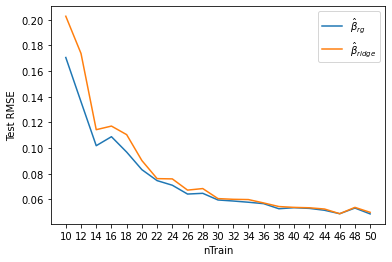

In [88]:
plt.plot(grad_means, label=r'$\hat{\beta}_{rg}$')
plt.plot(std_means, label=r'$\hat{\beta}_{ridge}$')
ax = plt.gca()
#ax.set_§aylim([0.03, 0.05])
plt.legend();
ax.set_xticks(range(len(Ntrain_samples)))
ax.set_xticklabels(Ntrain_samples);
ax.set_ylabel('Test RMSE')
ax.set_xlabel('nTrain');
#plt.savefig('beta_versus_betarg_rmse', facecolor='white')

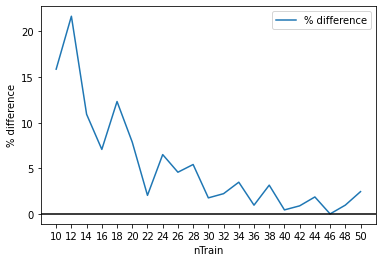

In [89]:
plt.plot((np.array(std_means)-np.array(grad_means))*100/np.array(std_means), label='% difference')
plt.axhline(0, c='black')
ax = plt.gca()
ax.set_xticks(range(len(Ntrain_samples)))
ax.set_xticklabels(Ntrain_samples);
ax.set_ylabel('% difference')
ax.set_xlabel('nTrain')
plt.legend();
#plt.savefig('beta_versus_betarg_diff', facecolor='white')